# Inferential Statistics III - Bayesian

## Introduction

In the last two subunits, you've encountered two schools for performing inference from samples. The Frequentist school calls upon a body of theory established over the past couple of centuries or so. Under certain assumptions and conditions, this allows us to calculate what we would expect to see if an experiment were to be repeated again and again and again. The expected value of the average of a sample is one such statistic we can calculate a result for, even if the originating distribution is far from normal. The bootstrap school, on the other hand, literally does (virtually) run that experiment again and again and again and empirically observes the multitude of outcomes. It then empirically calculates a statistic of interest. While this can be for exactly the same statistics that frequentism calculates (e.g. the mean of a sample) this empirical approach can also perform inference on statistics that do not have well known sampling distributions. Because of the requirement to repeat many, many redraws (with replacement) from the sample, this approach only became feasible with modern computing power.

And thus we come to the Bayesian school of inference. Here we frame our probabilities not so much in terms of "how many times would I expect this event to occur if the experiment were to be rerun many times" but rather in terms of "what is my belief in the likelihood of this event occurring?" In a Bayesian probabilistic programming context, we can build models for systems and then let the data tell us how likely certain values for our model parameters are. This can be a very useful way to incorporate prior knowledge and deal with limited data. It can just be more than a _little_ fiddly to produce a good model!

## Medical charge data set

For the final mini-project of the stats unit, you'll once again return to the medical charge data you've used for the other mini-projects. Previously, we considered whether we believed that the actual average(non-insured) charge had fallen below a certain threshold.

The hospital is now reviewing its financial resiliency plan, which requires a model for revenue under a range of conditions that include the number of patients treated. Its current model is based on a confidence interval for the mean, and scaling that by different numbers of patients for each scenario. This approach has a number of limitations, most acutely the breakdown of the central limit theorem for low patient volumes; the current model does not do a good job of reflecting the variability in revenue you would see as the number of cases drops. A bootstrap approach would return samples of the same size as the original. Taking subsamples would restrict the sampling to the values already present in the original sample and would not do a good job of representing the actual variability you might see. What is needed is a better model of individual charges.

So the problem here is that we want to model the distribution of individual charges and _we also really want to be able to capture our uncertainty about that distribution_ so we can better capture the range of values we might see. This naturally leads us to a powerful, probabilistic approach — we'll use the pymc3 library to perform Bayesian inference.

### Loading the data and performing an initial view

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma
# there has been some incompatibilty between theano and numpy, if you encounter
# an error with the latest packages from anaconda, then the included
# package-list-txt should allow you to create a conda environment with compatible
# packages.

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
medical = pd.read_csv('data/insurance2.csv')

In [3]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [4]:
insurance = medical.charges[medical.insuranceclaim == 1]
no_insurance = medical.charges[medical.insuranceclaim == 0]
n_ins = len(insurance)
n_no_ins = len(no_insurance)

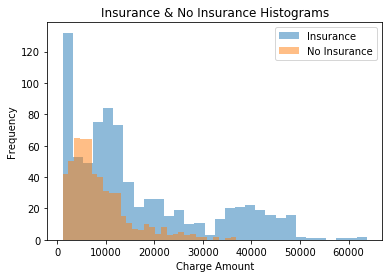

In [5]:
_ = plt.hist(insurance, bins=30, alpha=0.5, label='Insurance')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='No Insurance')
_ = plt.title('Insurance & No Insurance Histograms')
_ = plt.xlabel('Charge Amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

We may suspect from the above that there is some sort of exponential-like distribution at play here; the charges that were not insurance claims seem most like this, because insurance claim charges may possibly be multimodal. The gamma distribution may be applicable and we could test this for the distribution of charges that weren't insurance claims first. Developing our new method for the easiest looking case first is a common and sound approach that can demonstrate a minimum viable solution/product and get, or keep, stakeholders on board.

### Initial parameter estimation

An initial guess for the gamma distribution's $\alpha$ and $\beta$ parameters can be made as described [here](https://wiki.analytica.com/index.php?title=Gamma_distribution).

In [6]:
alpha_est = np.mean(no_insurance)**2 / np.var(no_insurance)
beta_est = np.var(no_insurance) / np.mean(no_insurance)

print("Estimates\n---------")
print('Alpha: {:.2f}'.format(alpha_est))
print('Beta: ${:,.2f}'.format(beta_est))

Estimates
---------
Alpha: 1.88
Beta: $4,702.49


### Initial simulation

Let's draw the same number of random variates from this distribution and compare to our observed data.

In [7]:
seed(47)
no_ins_model_rvs = gamma(alpha_est, scale=beta_est).rvs(n_no_ins)

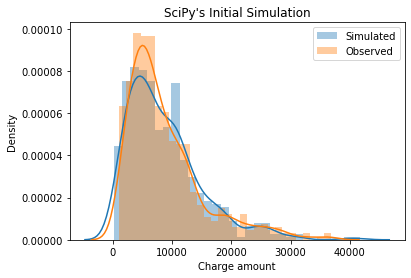

In [8]:
sns.distplot(no_ins_model_rvs, bins=30, label='Simulated')
sns.distplot(no_insurance, bins=30, label='Observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Density')
_ = plt.title("SciPy's Initial Simulation")
_ = plt.legend()

Well it doesn't look too bad! We're not a million miles off. But can we do better? We have a plausible form for the distribution of charge amounts and potential values for that distribution's parameters so we can already draw random variates from that distribution to perform simulations. But we don't know if we have a _best_ estimate for the population parameters, and we also only have a single estimate each for $\alpha$ and $\beta$; we aren't capturing our uncertainty in their values. Can we take a Bayesian inference approach to estimate the parameters?

### Creating a PyMC3 model

In [9]:
# PyMC3 Gamma seems to use rate = 1/beta
rate_est = 1 / beta_est
# Initial parameter estimates we'll use below
print('Initial Parameter Estimates\n---------------------------')
print('Alpha: {:.5f}'.format(alpha_est))
print(' Rate: {:.5f}'.format(rate_est))

Initial Parameter Estimates
---------------------------
Alpha: 1.87591
 Rate: 0.00021


__Q:__ You are now going to create your own PyMC3 model!
1. Use an [exponential](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Exponential) prior for alpha. Call this stochastic variable `alpha_`.
2. Similarly, use an exponential prior for the rate ([$1/\beta$](https://wiki.analytica.com/index.php?title=Gamma_distribution)) parameter in PyMC3's [Gamma](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma). Call this stochastic variable `rate_` (but it will be supplied as `pm.Gamma`'s `beta` parameter). Hint: to set up a prior with an exponential distribution for $x$ where you have an initial estimate for $x$ of $x_0$, use a scale parameter of $1/x_0$.
5. Create your Gamma distribution with your `alpha_` and `rate_` stochastic variables and the observed data.
6. Perform 10000 draws.

Hint: you may find it helpful to work backwards. Start with your `pm.Gamma`, and note the required stochastic variables `alpha` and `beta`. Then, before that, you need to create those stochastic variables using `pm.Exponential` and the correct parameters.

In [10]:
with pm.Model() as model:
    alpha_ = pm.Exponential('alpha_', 1 / alpha_est)
    rate_ = pm.Exponential('rate_', 1 / rate_est)
    beta_ = pm.Deterministic('beta_', 1 / rate_)
    gamma_ = pm.Gamma('gamma_', alpha_, rate_, observed=no_insurance)
    
    trace = pm.sample(draws=2500, tune=1000, cores=4, random_seed=47)

with model:
    post_pred = pm.sample_posterior_predictive(trace, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rate_, alpha_]
Sampling 4 chains: 100%|██████████| 14000/14000 [00:37<00:00, 370.01draws/s]


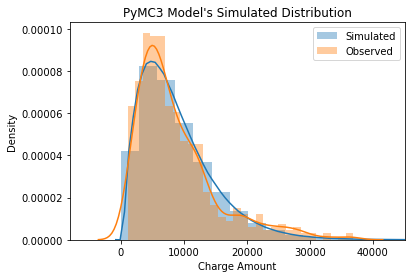

In [11]:
# model's predicted charges
post_gamma = post_pred['gamma_']
post_gamma_all = np.concatenate(post_gamma)

# plot PyMC3's model distribution
sns.distplot(post_gamma_all, bins=30, label='Simulated')
sns.distplot(no_insurance, bins=30, label='Observed')
plt.xlim(right=45000)
plt.xlabel('Charge Amount')
plt.ylabel('Density')
plt.title("PyMC3 Model's Simulated Distribution")
plt.legend()
plt.show()

>__A:__ The PyMC3 model was created by setting exponential priors for alpha and rate using their inverse value as the lambda parameter for the exponential distribution; in order to analyze beta after the model is trained, a deterministic value for beta was created by taking the reciprocal of the rate. Finally, the gamma distribution was given the alpha and rate values to create and tune the updated gamma distribution. The model was sampled with 4 chains with 2,500 samples per chain for a total of 10,000 samples; the model was tuned on 1,000 additional samples per chain for a total of 4,000 tuning samples. 

__Q:__ Explore your posteriors for $\alpha$ and $\beta$ (from the trace).
* Calculate the 95% credible interval for $\alpha$ and $\beta$.
* Plot your posterior values of $\alpha$ and $\beta$ (both line plots and histograms). 
* Mark your CIs on the histograms.
* Do they look okay? What would bad plots look like?

In [12]:
# all posterior stats
post_stats = pm.summary(trace)

# posterior alpha stats
alpha_post = trace.alpha_
alpha_stats = post_stats.iloc[0]
alpha_mean = alpha_stats['mean']
alpha_ci = alpha_stats[['hpd_2.5', 'hpd_97.5']]

# posterior beta stats
beta_post = trace.beta_
beta_stats = post_stats.iloc[2]
beta_mean = beta_stats['mean']
beta_ci = beta_stats[['hpd_2.5', 'hpd_97.5']]

/Users/sergiorobledo/miniconda3/envs/bayes/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


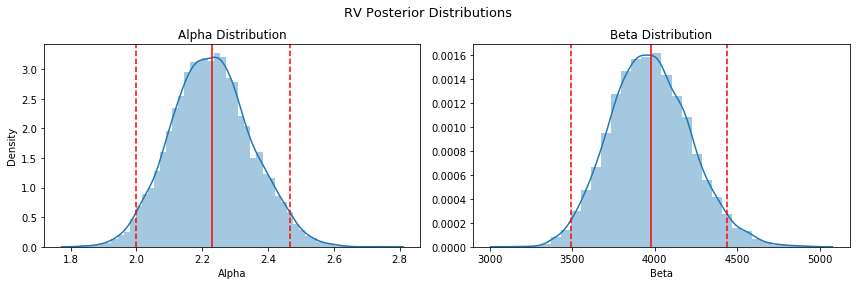

Alpha
-----
  Mean:..... 2.23
95% CI: [2.00 - 2.47]

Beta
----
  Mean:....... $3,975.19
95% CI: [$3,492.78 - $4,435.88]


In [13]:
fig = plt.figure(figsize=(12, 4))
fig.suptitle('RV Posterior Distributions', fontsize=13)

# plot alpha 
plt.subplot(1,2,1)
sns.distplot(alpha_post)
plt.axvline(alpha_mean, color='r')
plt.axvline(alpha_ci[0], color='r', linestyle='--')
plt.axvline(alpha_ci[1], color='r', linestyle='--')
plt.title('Alpha Distribution')
plt.ylabel('Density')
plt.xlabel('Alpha')

# plot beta
plt.subplot(1,2,2)
sns.distplot(beta_post, bins=30, norm_hist=True)
plt.axvline(beta_mean, color='r')
plt.axvline(beta_ci[0], color='r', linestyle='--')
plt.axvline(beta_ci[1], color='r', linestyle='--')
plt.title('Beta Distribution')
plt.xlabel('Beta')

fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

print('Alpha\n-----')
print("  Mean:..... {:.2f}".format(alpha_mean))
print("95% CI: [{:.2f} - {:.2f}]\n".format(alpha_ci[0], alpha_ci[1]))

print('Beta\n----')
print("  Mean:....... ${:,.2f}".format(beta_mean))
print("95% CI: [${:,.2f} - ${:,.2f}]".format(beta_ci[0], beta_ci[1]))

>__A:__ Both RVs strongly resemble a normal distribution, because both are based on the mean and variance of the sample; both frequentist and bootstrap statistics state that the mean and variance of samples should follow a normal distribution regardless of the distribution from which the samples are being acquired. Any distribution other than a normal distribution would be a bad distribution for alpha and beta, since they are proportional to the mean and standard deviation. 

__Q:__ Play around with some of the built-in diagnostic plots for your model. We suggest at least checking out the traceplot for alpha and beta. How do they look?

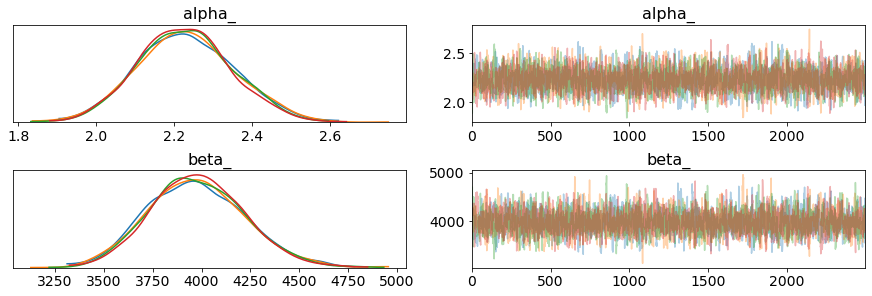

In [14]:
# plot traceplot
pm.traceplot(trace, var_names=['alpha_', 'beta_'])
plt.show()

>__A:__ The traceplot for four chains of the model can be seen above; the plots show good behavior as they show converging behavior for both alpha and beta. From the traceplots on the right, it can be noted that all four chains for alpha and beta are scattered around a mean value of about 2.5 and 4000 for alpha and beta, respectively; if each chain were to veer off to different estimates, it would mean that the model did not converge, because all four chains predicted wildly different values for the RVs. Further confirmation of the convergence of alpha and beta can be seen from the left hand side kernel density estimates; the kde plots confirm that all four chains of the model agreed on a similar value for the RVs. However, it is important to note that a small variance between chains is important, since it shows that there is no point in the tuning of the model where it overfits a certain aspect of the samples; this small variation between chains can be better seen in the kde plots where the each chain's kde resemble each other but do not perfectly overlap. 

__Q:__ Take your best shot at a new simulated sequence of medical charges using scipy.stat's gamma distribution. Don't forget the difference between functions that take $\beta$ and functions that use $1/\beta$ for the scale parameter. Simulate a data set the same size as the number of observations in the data and overlay the two histograms (simulated and observed).

In [15]:
# simulate gamma distribution
prior_scipy = []
post_scipy = []
for _ in range(10000):
    prior_scipy.append(gamma(alpha_est, scale=beta_est).rvs(n_no_ins))
    post_scipy.append(gamma(alpha_mean, scale=beta_mean).rvs(n_no_ins))
    
    
prior_scipy = np.concatenate(prior_scipy)
post_scipy = np.concatenate(post_scipy)

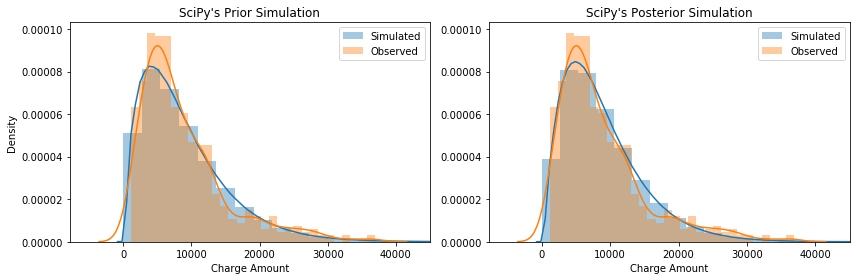

In [16]:
plt.figure(figsize=(12, 4))

# plot prior simulation
plt.subplot(1,2,1)
sns.distplot(prior_scipy, bins=30, label='Simulated')
sns.distplot(no_insurance, bins=30, label='Observed')
plt.xlim(right=45000)
plt.xlabel('Charge Amount')
plt.ylabel('Density')
plt.title("SciPy's Prior Simulation")
plt.legend()

# plot posterior simulation
plt.subplot(1,2,2)
sns.distplot(post_scipy, bins=30, label='Simulated')
sns.distplot(no_insurance, bins=30, label='Observed')
plt.xlim(right=45000)
plt.xlabel('Charge Amount')
plt.title("SciPy's Posterior Simulation")
plt.legend()

plt.tight_layout()
plt.show()

>__A:__ In order to accentuate the difference between SciPy's prior and posterior simulations of the observed datasets and reduce the effect of chance, the gamma simulations for both scenarios was ran 10,000 times; the prior simulations used the alpha and beta estimates acquired from the observed dataset, while the posterior simulations used the PyMC3 model's posterior means of alpha and beta. From comparing both histograms, it can clearly be seen that using a tuned alpha and beta approximate the observed dataset better than the initial alpha and beta estimates; however, it is impressive as to how well SciPy's gamma distribution was able to approximate the observed dataset using only initial priors. 

## Summary

In this exercise, we have postulated a distribution to describe the individual charge amounts for non-insured cases. This distribution has two required parameters, which we do not know, but we used PyMC3 to perform Bayesian inference to find our level of "belief" in a range of values for them. We then used the average parameter values to create one simulated data set of the same size as the original, but the distribution of our posteriors for these parameters will allow us to perform simulations of any sample size we desire and for a range of scenarios of different $\alpha$ and $\beta$. This could be a powerful tool to model different financial conditions for the hospital. 

Well done making it through this tricky subject. Starting think Bayesian _and_ starting to get to grips with something like PyMC3 is no easy task. As a data scientist, the most important thing is to be aware that this statistical approach exists, though you may not actually use this approach as much as you use the other approaches you've learned about. Still, we encourage you to think of ways that this approach could apply to the work that you do in this course and throughout your career.  